# Test SST Indices Calculations

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import cftime
import xarray

%matplotlib inline

In [2]:
import sys
sys.path.append(sys.path[0]+'/../..')


import helpers.fileHandler as fh
import utils.sstIndex as sst
import utils._indexDefinitions as _index

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#get a list of index names to iterate, and then add indian ocean dipole, as a special case
indexNames = list(_index.sstIndex.keys())
indexNames.append('dmi')

In [5]:
def plotter():

    keysCvdp = ['nino34', 'dmi']
    keysIndex = ['nino34NoDetrend', 'dmi']

    for i in [0,1]:

        try:
            #test if this is an index in cvdp
            cvdp[keysCvdp[i]]

        except:
            print (keysCvdp[i], " not defined in Cvdp")        

        else:
            #plot

            #load into memory so it doesn't get loaded twice if we want to use it later
            indexDs[keysIndex[i]].load()

            # set-up plot
            fig = plt.figure(figsize=(15,6))
            #fig.set_tight_layout(tight={'h_pad':1})
            
            ax1 = fig.add_subplot(2, 1, 1)

            #plot the cvdp
            cvdp[keysCvdp[i]].plot(color='orange' ,label='from CVDP')
            
            
            #set the horizontal axis to something nice
            plt.xlim(
                cftime.DatetimeNoLeap(1850,1,1), cftime.DatetimeNoLeap(2000,1,1))
            
            plt.ylabel("CVDP", fontsize=16)
            plt.xticks(visible=False)
            #make it neat
            plt.tick_params(which = 'minor', labelsize=13, length=4)
            plt.tick_params(which = 'major', labelsize=13, length=7)
            ax1.grid(which='major', alpha=0.3, linestyle='dashed')
            
            
            
            # set-up plot
            ax2 = fig.add_subplot(2, 1, 2)
            plt.subplots_adjust(hspace=0)
            #plot the calculated one
            indexDs[keysIndex[i]].plot(color='green',label='calculated')

            #set the horizontal axis to something nice
            plt.xlim(
                cftime.DatetimeNoLeap(1850,1,1), cftime.DatetimeNoLeap(2000,1,1))

            #add axis names and title
            #plt.title(keysCvdp[i].capitalize())
            plt.ylabel("Calculated", fontsize=16)  
            plt.xlabel("Year", fontsize=16)

            #make it neat
            plt.tick_params(which = 'minor', labelsize=13, length=4)
            plt.tick_params(which = 'major', labelsize=13, length=7)
            ax2.grid(which='major', alpha=0.3, linestyle='dashed')

            #show the legend based on the 'labels' set above
            #plt.legend()

            #make it so
            plt.show()

            print(keysCvdp[i], " standard deviation of difference: ", 
                  (indexDs[keysIndex[i]]-cvdp[keysCvdp[i]]).std().values)


First load up the cvdp and figure out the details of the index we want to calculate

In [18]:
cvdp = fh.loadModelData('CESM-LME', 'cvdp_data', '005')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


In [19]:
cvdp.time

<xarray.DataArray 'time' (time: 13872)>
array([cftime.DatetimeNoLeap(850, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(850, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(850, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2005, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00

Do a sanity check of what the areas are to calculate the indeces

In [20]:
for keys in indexNames:
    try:
        print(keys, ": ", cvdp[keys].comment_cvdp)
    except:
        print (keys, " not defined in Cvdp")



nino34 :  area average domain (-5:5N, 190:240E)
nino4 :  area average domain (-5:5N, 160:210E)
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp
dmi :  area average domain (-10:10N, 50:70E) - (-10:0N, 90:110E)


Next load the model outputs, but drop all the variables we don't care about

In [21]:
ds = fh.loadModelData('CESM-LME', 'SST', '005',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

In [22]:
ds.SST

<xarray.DataArray 'SST' (time: 13872, z_t: 1, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(13872, 1, 384, 320), dtype=float32, chunksize=(1872, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00
Dimensions without coordinates: z_t, nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

# Calculate the indeces from the model outputs

In [23]:
climatDs= sst.calculateClimatology(ds)     #based on 850 to 2005 climatology per CVDP

In [24]:
indexDs = sst.calculateIndex(ds, climatDs) 

Ds looks like CESM


In [25]:
indexDs.time

<xarray.DataArray 'time' (time: 13872)>
array([cftime.DatetimeNoLeap(850, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(850, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(850, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2005, 10, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

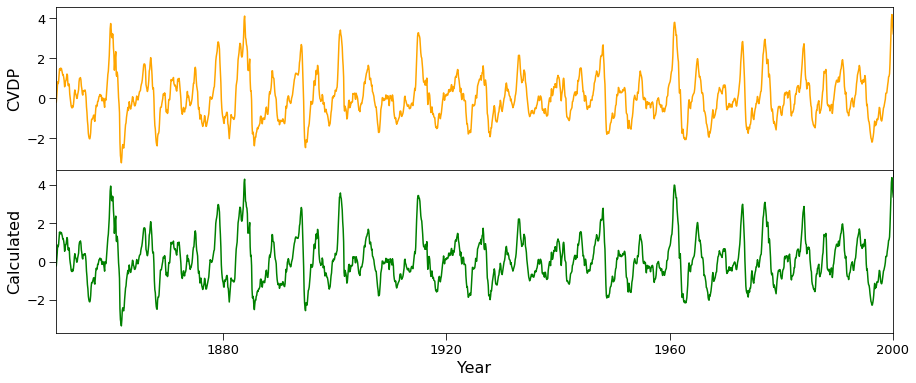

nino34  standard deviation of difference:  0.054329349919590826


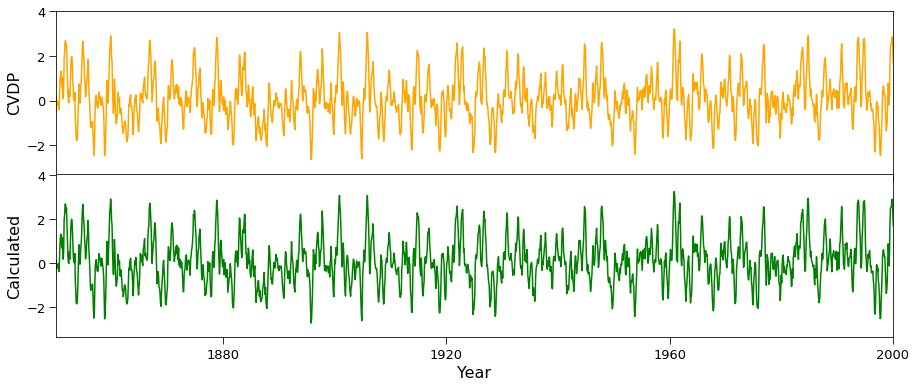

dmi  standard deviation of difference:  0.04375477175014187


In [84]:
plotter()

Do a comparison plot. Between calculated indexes and cvdp

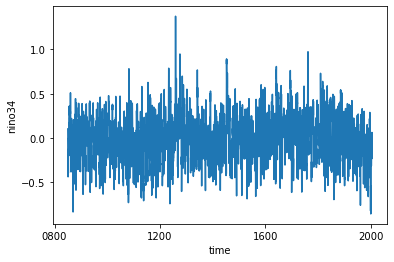

In [27]:
#Compare calulcate nino to the cvdp version
(indexDs.nino34-cvdp.nino34).plot()

In [28]:
#save the answer, in case we want it later
indexDs.to_netcdf("../results/monthlySstIndicesCalculated.nc")

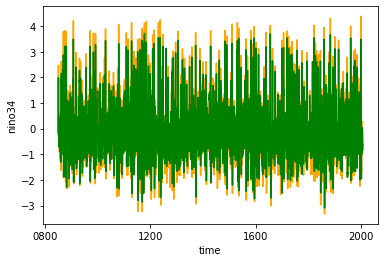

In [29]:
indexDs['nino34NoDetrend'].plot(color='orange',label='calculated')
indexDs['nino34'].plot(color='green',label='detrended')

# Same again, but use the climatology from the control run

In [30]:
experimentDs = fh.loadModelData('CESM-LME', 'SST', '005',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

Load the ds to use for climatology

In [31]:
controlDs = fh.loadModelData('CESM-LME', 'SST', '0850cntl.001',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

Calculate the indeces from the model outputs

In [85]:
climatDs = sst.calculateClimatology(controlDs) #based on 850 to 2005 climatology per CVDP


In [86]:
indexDs = sst.calculateIndex(experimentDs, climatDs) 

Ds looks like CESM


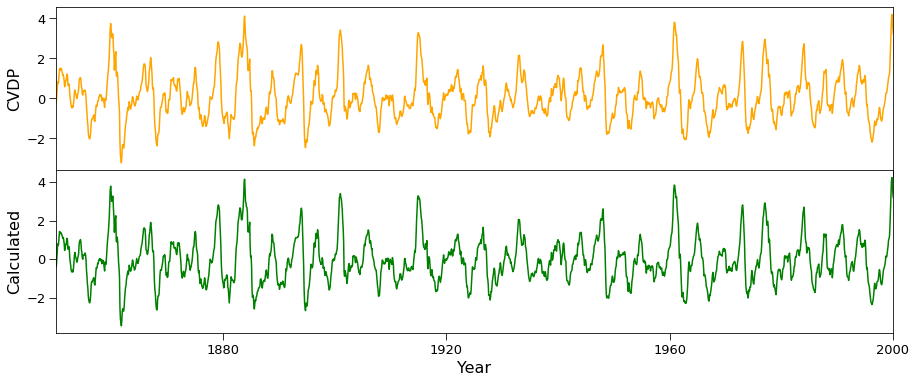

nino34  standard deviation of difference:  0.0660329394433925


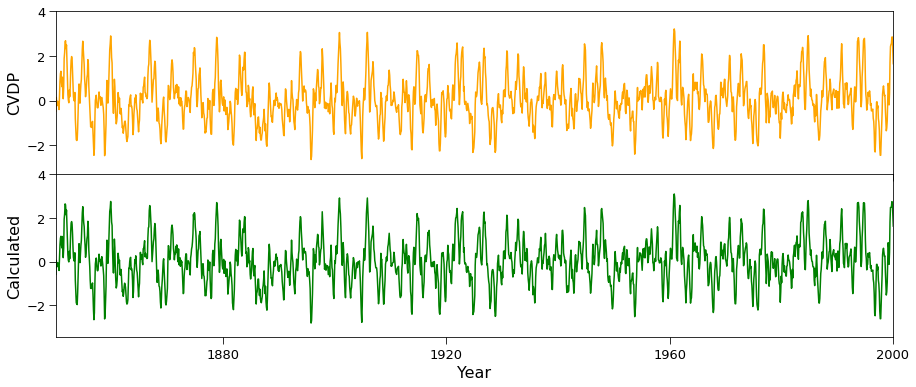

dmi  standard deviation of difference:  0.07019327070866603


In [87]:
plotter()

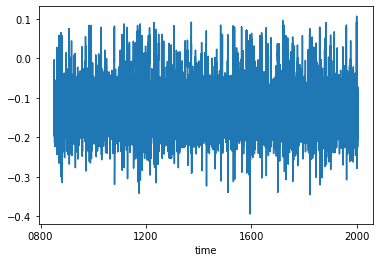

In [88]:
#Compare calulcate nino to the cvdp version
(indexDs.nino34NoDetrend-cvdp.nino34).plot()

In [ ]:
#save the answer, in case we want it later
indexDs.to_netcdf("../results/monthlySstIndicesCalculatedDiffClimatology.nc")

In [ ]:
indexDsStandClimat = xarray.open_dataset('../results/monthlySstIndicesCalculated.nc')

In [ ]:
# set-up plot
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 1, 1)
#plot the calculated one
indexDs['nino34'].plot(color='orange',label='calculated')
indexDsStandClimat['nino34'].plot(color='green',label='calculated')
   #set the horizontal axis to something nice
plt.xlim(cftime.DatetimeNoLeap(1750,1,1), cftime.DatetimeNoLeap(2050,1,1))


# And again with CMIP6

In [13]:
model='BCC-CSM2-MR'
variant='r1i1p1f1'

In [14]:
cvdp = fh.loadModelData(model, 'cvdp_data', 'historical', variant)

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


Not found on Gadi
/g/data/oi10/replicas/cmip6.historical.cvdp_data/BCC/BCC-CSM2-MR/historical/r1i1p1f1/data/cvdp//
['']
Making request file
b''


In [15]:
cvdp.climatology

'1920-2014 climatology removed prior to all calculations (other than means)'

In [16]:
cvdp

<xarray.Dataset>
Dimensions:                         (LAT: 160, LON: 320, TIME: 95, frequency: 570, lat: 160, lon: 320, longitude: 142, ncurves: 4, period: 122, time: 1140, time_mon1: 29, time_mon2: 12, time_mon3: 49)
Coordinates: (12/13)
  * LAT                             (LAT) float64 -89.14 -88.03 ... 88.03 89.14
  * LON                             (LON) float64 0.0 1.125 2.25 ... 357.8 358.9
  * TIME                            (TIME) int32 1920 1921 1922 ... 2013 2014
  * frequency                       (frequency) float32 0.0008772 ... 0.5
  * lat                             (lat) float64 -89.14 -88.03 ... 88.03 89.14
  * lon                             (lon) float64 0.0 1.125 2.25 ... 357.8 358.9
    ...                              ...
  * ncurves                         (ncurves) int32 0 1 2 3
  * period                          (period) float32 0.08609 0.09121 ... 93.39
  * time                            (time) object 1920-01-31 00:00:00 ... 201...
  * time_mon1                       (time_mon1) int32 0 1 2 3 4 ... 25 26 27 28
  * time_mon2                       (time_mon2) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * time_mon3                       (time_mon3) int32 0 1 2 3 4 ... 45 46 47 48
Data variables: (12/339)
    amo_pattern_lowpass_mon         (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    amo_pattern_mon                 (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    amo_pr_regression_lowpass_mon   (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    amo_pr_regression_mon           (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    amo_spectra                     (ncurves, frequency) float32 dask.array<chunksize=(4, 570), meta=np.ndarray>
    amo_tas_regression_lowpass_mon  (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    ...                              ...
    tas_trends_djf                  (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    tas_trends_jja                  (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    tas_trends_mam                  (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    tas_trends_mon                  (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    tas_trends_son                  (lat, lon) float32 dask.array<chunksize=(160, 320), meta=np.ndarray>
    tropical_indian_ocean           (time) float32 dask.array<chunksize=(1140,), meta=np.ndarray>
Attributes:
    source:       NCAR Climate Analysis Section's Climate Variability Diagnos...
    notes:        Data from BCC-CSM2-MR r1i1p1f1 from 1920-2014
    climatology:  1920-2014 climatology removed prior to all calculations (ot...
    Conventions:  CF-1.6
    history:      Fri Feb 26 07:09:06 2021: ncks -O /project/diagnostics/exte...
    NCO:          "4.5.2"

In [17]:
tsDs = fh.loadModelData(model, 'tos_Omon', 'historical', variant).tos.to_dataset()
tsDs=tsDs.assign_attrs({'project_id':'CMIP'})


Using model as climatology

In [18]:
tsDs

<xarray.Dataset>
Dimensions:    (lat: 232, lon: 360, time: 1980)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    latitude   (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
Data variables:
    tos        (time, lat, lon) float32 dask.array<chunksize=(1980, 232, 360), meta=np.ndarray>
Attributes:
    project_id:  CMIP

In [19]:
climatDs=sst.calculateClimatology(tsDs, 1920, 2014)

indexDs = sst.calculateIndex(tsDs, climatDs) 

In [20]:
indexDs

<xarray.Dataset>
Dimensions:                 (time: 1980)
Coordinates:
  * time                    (time) object 1850-01-16 00:00:00 ... 2014-12-16 ...
    month                   (time) int64 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    nino34NoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4NoDetrend          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    westIONoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIONoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSstNoDetrend  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dmi                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino34                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4                   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    westIO                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIO                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSst           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [22]:
cvdp.nino34

<xarray.DataArray 'nino34' (time: 1140)>
dask.array<open_dataset-8bf0ef8bba065bc80e8c2c7b96df52d5nino34, shape=(1140,), dtype=float32, chunksize=(1140,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1920-01-31 00:00:00 ... 2014-12-31 00:00:00
Attributes:
    standard_name:  surface_temperature
    long_name:      nino3.4 timeseries (monthly)
    comment:        Temperature of the lower boundary of the atmosphere
    units:          C
    original_name:  TS
    comment_cvdp:   area average domain (-5:5N, 190:240E)

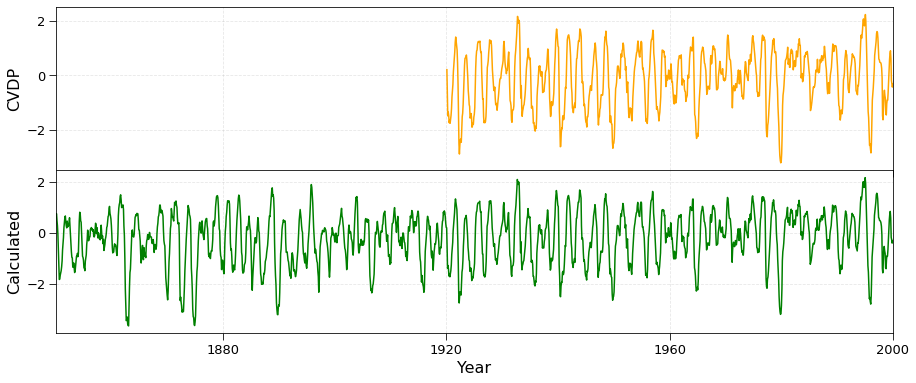

nino34  standard deviation of difference:  nan


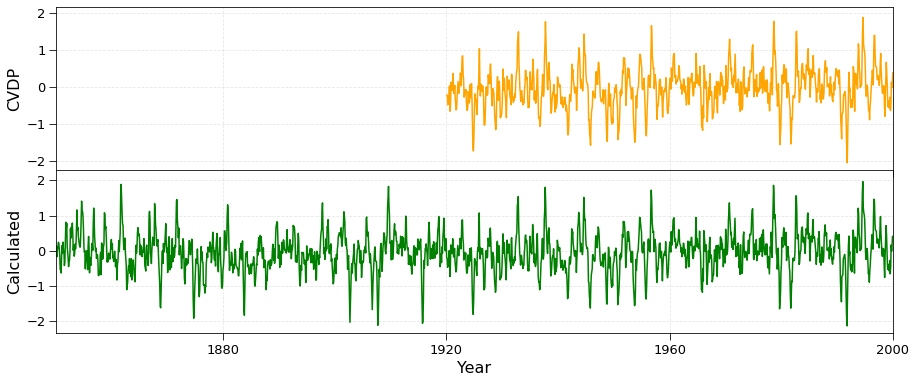

dmi  standard deviation of difference:  nan


In [23]:
plotter()

Using control run as climatology

In [24]:
cvdp = fh.loadModelData('CNRM-CM6-1', 'cvdp_data', 'historical', 'r1i1p1f2')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


Not found on Gadi
/g/data/oi10/replicas/cmip6.historical.cvdp_data/CNRM-CERFACS/CNRM-CM6-1/historical/r1i1p1f2/data/cvdp//
['']
Making request file
b''


In [25]:
tsDs = fh.loadModelData('CNRM-CM6-1', 'tos_Omon', 'historical', 'r1i1p1f2').tos.to_dataset()
tsDs=tsDs.assign_attrs({'project_id':'CMIP'})


Using CVDP climatology

In [26]:
indexDs = sst.calculateIndex(tsDs,1920,2014) 

In [27]:
indexDs

<xarray.Dataset>
Dimensions:                 (time: 1980)
Coordinates:
  * time                    (time) object 1850-01-16 00:00:00 ... 2014-12-16 ...
    month                   (time) int64 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    nino34NoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4NoDetrend          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    westIONoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIONoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSstNoDetrend  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dmi                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino34                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4                   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    westIO                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIO                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSst           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

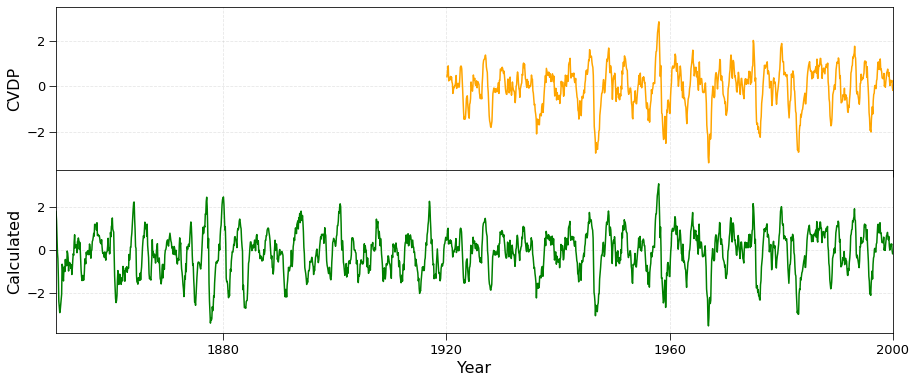

nino34  standard deviation of difference:  nan


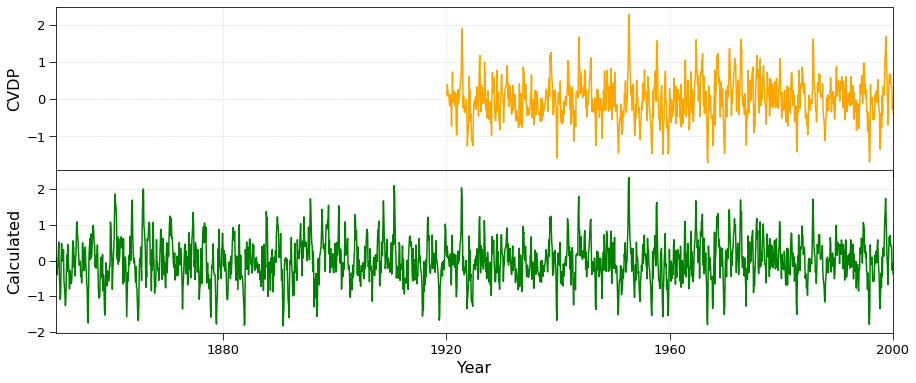

dmi  standard deviation of difference:  nan


In [28]:
plotter()

Using pi Control as climat

In [29]:
indexDs = sst.calculateIndex(tsDs, climatDs) 

In [30]:
indexDs

<xarray.Dataset>
Dimensions:                 (time: 1980)
Coordinates:
  * time                    (time) object 1850-01-16 00:00:00 ... 2014-12-16 ...
    month                   (time) int64 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    nino34NoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4NoDetrend          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    westIONoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIONoDetrend         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSstNoDetrend  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dmi                     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino34                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4                   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    westIO                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIO                  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSst           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

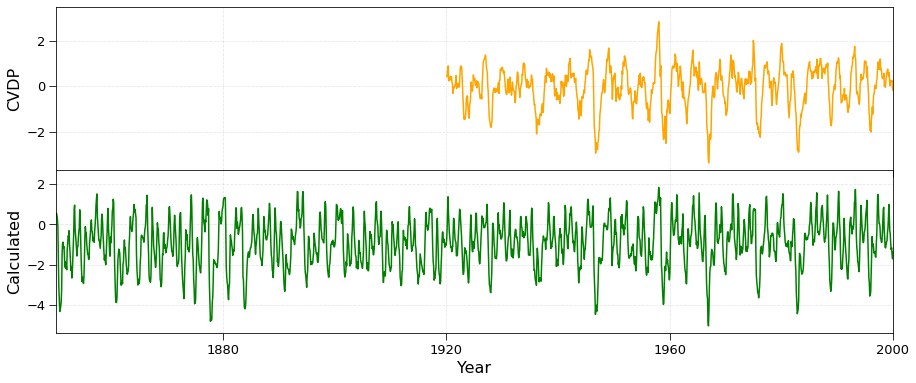

nino34  standard deviation of difference:  nan


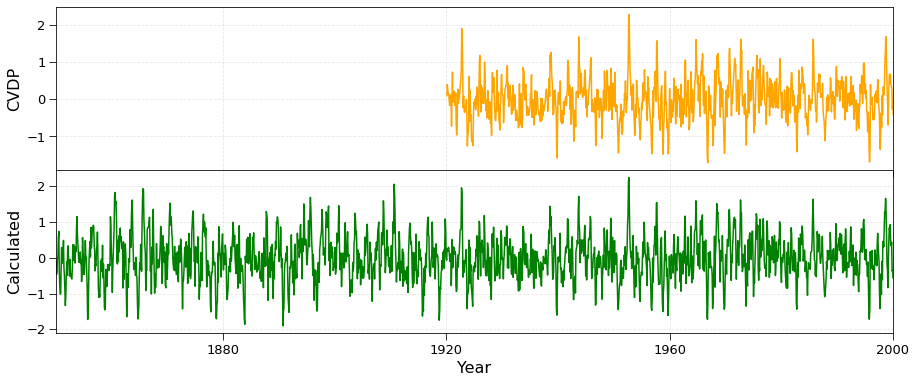

dmi  standard deviation of difference:  nan


In [31]:
plotter()

And for a scenario

In [32]:
cvdp = fh.loadModelData('CNRM-CM6-1', 'cvdp_data', 'ssp370', 'r1i1p1f2')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


Not found on Gadi
/g/data/oi10/replicas/cmip6.ssp370.cvdp_data/CNRM-CERFACS/CNRM-CM6-1/ssp370/r1i1p1f2/data/cvdp//
['']
Making request file
b''


OSError: Requested files /scratch/w35/as2285/cmip6.ssp370.cvdp_data/ not found. Is the harddrive plugged in?

In [ ]:
tsDs = fh.loadModelData('CNRM-CM6-1', 'ts_Amon', 'ssp370', 'r1i1p1f2').ts.to_dataset()
tsDs=tsDs.assign_attrs({'project_id':'CMIP'})


In [ ]:
indexDs = sst.calculateIndex(tsDs, 2015, 2099) 

In [ ]:
plotter()